**This notebook borrows most of the code of Scatterplot. Its objective is to test different parameters for the clusterization of DBSCAN and HDBSCAN.**

Code for chunks shared with the Scatterplot notebook are the same. The descriptions of what each subsection does are omitted for those shared chunks.

#### Data Load

In [2]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


In [3]:
#So far the data is divided in an initial set and a series of additionla batches of data (so far one).

#ids will save the ids of the sample (SRAs), projects will save the bioproject identifiers (PJRNA).
ids=[]
projects=[]

#The ids and corresponding project of the first batch is loaded first from Proj_UID. Proj_UID was generated
#in the ProjectMatch notebook. in the Match folder.
FirstBatch=open("Proj_UID.csv","r")

for line in FirstBatch:
    line=line.strip("\n").split(";")
    ids.append(line[0])
    projects.append(line[1])

In [4]:
#The second batch is loaded in the same way. Proj_UIDBatch2 was generated
#in the CheckforNew notebook in the Distances folder.
SecondBatch=open("Proj_UIDBatch2.csv","r")

for line in SecondBatch:
    line=line.strip("\n").split(";")
    
    if line[0] in ids:
        continue
    else:
        ids.append(line[0])
    projects.append(line[1])

In [6]:
#Now we load the Mash distances. Here they are loaded in the tabular output format of Mash Triangle 
#generated with the -E flag (if I'm not wrong).
phy=open("NewDistances.tab","r")

#The distances are saved in a matrix. The dimensions of the matrix can be found by determining the length
#of ids.
distances=np.zeros((1617,1617))

#At each line the tab file is parsed and the distances added. The file includes, amongst others, the 
#id of all pairs of samples and their distance. We parse the ids and distance and place the distance in
#the corresponding spot in the distance matrix, so that the order of samples in the list ids corresponds 
#to the distances in the matrix.
for line in phy:
    line=line.strip("\n").split("\t")
    id1=line[0].split("_")[0].split("/")[1]
    id2=line[1].split("_")[0].split("/")[1]
    dist=float(line[2])
    
    distances[ids.index(id1),ids.index(id2)]=dist
    distances[ids.index(id2),ids.index(id1)]=dist
phy.close()

In [7]:
#Hereon we're interested in a dereplicated list of all projects, so we dereplicate projects ans save as
#Ordprojects (for now).
Ordprojects=list(set(projects))
print(len(Ordprojects))

776


In [8]:
#We generate col, a list which will map every sample to a number, and that number to a given project, based
#on the order of appareance of the projects in Proj_UID and Proj_UIDBatch2. More on col below.
col=[]

for i in projects:
    col.append(Ordprojects.index(i))

In [9]:
#The original ordered project list, with the ith positions having the project of the ith id, is saved in
#UnOrdprojects, while the dereplicated list is now saved simply as projects.
UnOrdprojects=projects
projects=Ordprojects

#### Data Load (Keywords and MeSH)

In [10]:
#Now we move on to load the keywords and MeSH terms for the bioprojects which have them. In general almost
#all bioprojects have keywords, while only a handful have MeSH Terms.

#For keywords the file Papers-Grid_Min.csv (custom made based on the Airtable data) contains the title of the
#project (or paper if there's a paper), the bioproject identifier and the keywords from airtable.
fpapers=open("Papers-Grid_Min.csv","r",encoding="utf-8")

#We'll save the keywords per project in keywords and the projects corresponding to each set of keywords in
#ProjforKeywords. Note that we're mapping projects to keywords, not samples to keywords. Also, since 
#Papers-Grid_Min.csv was downloaded from Airtable, the order of the projects is not necessarily the same as 
#in the list projects generated above (that's why we need another list).
ProjforKeywords=[]
keywords=[]

for line in fpapers:
#We use the PRJNA in the project id as a separator and get the list of keywords from every project.
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]

#Since we're only interested in the keywords of the projects whose samples have Mash distances, we filter
#the projects and get the keywords of those which are present in Proj_UID.csv or Proj_UIDBatch2.csv.
        if projectID in projects:
            ProjforKeywords.append(projectID)
            Prelkeywords=line[1].split(",")[1::]
            Realkeywords=[]
            for i in Prelkeywords:
                if i=="":
                    continue
                else:
#keywords are added in lowercase.
                    Realkeywords.append(i.lower())
            keywords.append(Realkeywords)
fpapers.close()

In [11]:
#Now we define a dictionary which will store the projects (value) associated to each keyword (key) present
#in the dataset. 
kwordtoProj={}

for i in range(len(keywords)):
    for j in keywords[i]:
        if j in kwordtoProj.keys():
            kwordtoProj[j].append(ProjforKeywords[i])
        else:
             kwordtoProj[j]=[ProjforKeywords[i]]

In [12]:
#For MeSH terms we employ the file MeSHTerms.csv which contains the major and minor MeSH terms per 
#article and project. This csv is partly made with notebook Title_Description_Extraction.csv in 
#Match/Keywords_MeSH, and partly done manually.

MeShTerms=open("MeSHTerms.csv","r",encoding="utf-8")

#We generate lists to hold the major and minor MeSH terms per bioproject (MeSHMaj and MeSHMin), and the 
#bioprojects which have them in the order they are found in MeSHTerms.csv
ProjforMeSH=[]
MesHMaj=[]
MesHMin=[]

#These two are temporary lists for holding the terms associated to single bioprojects.
thisMaj=[]
tempMin=[]

#Due to the way the csv with the MeSH terms is structured, a variable with the first project id in the file
#needs to be defined.
Currentproject="PRJNA450123"

#Now the meSH terms are loaded.
while True:
    line = MeShTerms.readline()
    if line is None or line=='':
        break
    else:
#The file has one line per Major-Minor MeSh term combination in each specific project, so there are many
#lines associated to each project.
        line=line.strip("\n").split(";")
        if line[1]==Currentproject:
            thisMaj.append(line[2])
            thisMin=[]
#While the same bioproject appears in the following line, we add Major and Minor terms into temporary lists.
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
#When the bioproject changes we save the terms of the prior bioproject in their corresponding lists.
        else:
            MesHMaj.append(thisMaj)
            MesHMin.append(tempMin)
            Currentproject=line[1]
            ProjforMeSH.append(line[1])
            thisMaj=[line[2]]
            tempMin=[]
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
    
MeShTerms.close()

In [13]:
#We generate dictionaries with the Major and Minor MeSH terms (key) and the bioprojects the're included
#in (value).

#Note that for minor MeSH terms we're considering the combination of the major and the minor term as a key,
#to avoid ambiguities.
MajMeSHtoProj={}
MinMeSHtoProj={}

for i in range(len(MesHMaj)):
    for j in range(len(MesHMaj[i])):
        if MesHMaj[i][j] in MajMeSHtoProj.keys():
            MajMeSHtoProj[MesHMaj[i][j]].append(ProjforMeSH[i])
        else:
             MajMeSHtoProj[MesHMaj[i][j]]=[ProjforMeSH[i]]
#Major and minor MeSH combinations are separated by _ to make them easily distinguishable.
        for z in MesHMin[i][j]:
            if MesHMaj[i][j]+"_"+z in MinMeSHtoProj.keys():
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z].append(ProjforMeSH[i])
            else:
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z]=[ProjforMeSH[i]]

#### Search abstracts for keywords

In [14]:
#Some of the projects we're working with have abstracts in Airtable which might contain the keywords which
#are associated to the projects. Therefore, it makes sense to look for keywords in the abstracts of the 
#projects, to make sure that all bioprojects which have a given keyword in their abstracts (but not in their
#original set of keywords) now have that keyword.

#Note that abstracts in Airtable might be shorts descriptions or paper abstracts per se, depending
#on the case.

#The abstracts are saved in Abstracts.csv, which contains the title of the project, the project ID, and the
#abstract itself.
abst=open("Abstracts.csv","r",encoding="utf-8")

while True:
    line = abst.readline()
    if line is None or line=='':
        break
#Due to the way the Airtable information must be downloaded, abstracts can span multiple lines in the file.
#We look for the PJRNA in the bioproject identifier and use that to identify the beggining of an abstract
#and save all its lines.
    else:
        if "PRJNA" in line:
            line=line.strip("\n").split("PRJNA")
            projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
            #print(projectID)
#Naturally we only consider projects whose samples have Mash distances.
            if projectID in projects:
                try:
#Some of the abstracts begin with double quotes, which are used to mark the beggining and end of them, so 
#they're used to parse them and mark the end of the abstract.
                    text=line[1].split('"')[-2]
                    while '"' not in text:
#When an abstract is found all its line are searched for the presence of any of the keywords. if any its find
#and its not already associated to the bioproject, the bioproject is added to the list of projects in the 
#keyword dictionary, and the keyword added to the list of keywords for that bioproject.
                        for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                                keywords[ProjforKeywords.index(projectID)].append(j)
                        text=abst.readline().strip("\n")
#For abstracts without double quotes we use commas.
                except IndexError:
                    text=line[1].split(',')[-1]
                    for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                                keywords[ProjforKeywords.index(projectID)].append(j)
abst.close()

#### Consolidate keywords by presence of specific words

In [ ]:
#Now we move on to consolidate keywords if necessary. Consolidate means group together keywords which directly 
#mean the same thing (Permanent or Primary Consolidation) and those which are related (Secondary Consolidation).

#Both consolidations are given by two csv files which are custom made: PermanentConsolidation.csv and 
#SecondaryConsolidation.csv. They contain in the first column the word in which the keywords will be consolidated 
#(consolidated term), and in the rest of the columns the keywords already present which will be consolidated 
#into the word in the first columns.

#We do the same procedure for both files. First we open them.
PC=open("PermanentConsolidation.csv","r")

#Then a dictionary is defined with the keys being the word to consolidate and the values lists of the present
#keywords to be consolidated into that word.
FirstConsolidate={}

for line in PC:
    line=line.strip("\n").split(";")
    
#The keywords present are appended in lower case to coincide with the ones in kwordtoProj.
    thisList=[]
    for i in line[1::]:
        if i!="":
            thisList.append(i.lower())
    FirstConsolidate[line[0]]=thisList

PC.close()

#The secondary consolidate file is parsed in the same way.
SC=open("SecondaryConsolidation.csv","r")

SecondaryConsolidate={}

for line in SC:
    line=line.strip("\n").split(";")
    
    thisList=[]
    for i in line[1::]:
        if i!="":
            thisList.append(i.lower())
#There are two terms which need to be handled uniquely due to they being consolidated terms for the first consolidation
#but being then consolidated into other term in the second consolidation.
        if "cabbage looper" in thisList:
            thisList[thisList.index("cabbage looper")]="Cabbage looper"
        if "16s" in thisList:
            thisList[thisList.index("16s")]="16S"
    SecondaryConsolidate[line[0]]=thisList

SC.close()

In [ ]:
#The function generate consolidation takes the dictionaries loaded from either PermanentConsolidation.csv or 
#SecondaryConsolidation.csv and updates kwordtoProj, keywords and ProjforKeywords so that the presence of the
#consolidated terms in the projects now shown, and the terms consolidated are erased from those objects.

#For the sake of generality, kwordtoProj, keywords and ProjforKeywords are not directly used in the function 
#definition, but they should be pased as the parameters wordDict,ProjWordList, and ProjtoWord.
def generateConsolidation(ConsolidateDict,wordDict,ProjWordList,ProjtoWord):
#The function first adds to wordDict the new consolidated terms as keys and the list of the bioprojects they're in
#as values. The consolidated terms are also added to the ordered list with keywords per bioproject. The terms to 
#be consolidated are added to the list toRemove.
    toRemove=[]
    for NewTerm in ConsolidateDict.keys():
        thisList=[]
        for OldTerm in ConsolidateDict[NewTerm]:
            thisList.extend(wordDict[OldTerm])
            toRemove.append(OldTerm)
        wordDict[NewTerm]=list(set(thisList))
#Here the consolidated terms are added to the ordered list of keywords per bioproject, and the terms to be consolidated
#are removed from it.
    for proj in ProjtoWord:
        for NewTerm in ConsolidateDict.keys():
            if proj in wordDict[NewTerm]:
                ProjWordList[ProjtoWord.index(proj)].append(NewTerm)
        for OldTerm in toRemove:
            if proj in wordDict[OldTerm]:
                while ProjWordList[ProjtoWord.index(proj)].count(OldTerm)!=0:
                    ProjWordList[ProjtoWord.index(proj)].remove(OldTerm)
#Finally, the terms to be consolidated are removed from the dictionary of keywords.
    for key in toRemove:
        try:
            del wordDict[key]
        except KeyError:
            pass

In [ ]:
#We run the first consolidation.
generateConsolidation(FirstConsolidate,kwordtoProj,keywords,ProjforKeywords)

In [ ]:
#And if necessary we run the second one.
generateConsolidation(SecondaryConsolidate,kwordtoProj,keywords,ProjforKeywords)

#### Modify Color Scheme based on given Keywords/MeSH Terms

In [15]:
#Now we move to the process of generating coloring schemes for graphing. Earlier we defined col, an ordered list
#in which each sample is assigned a number which corresponds to the position of its corresponding bioproject in
#the bioprojects list. That will be useful for coloring per project in the graphs. However, we might want to
#color by the presence of specific terms.

#change_col generates coloring schemes based on the presence of keywords or MeSH terms. dictOne refers to a MeSh or
#keyword dictionary, words the terms to be used for the coloring shceme, and all_col whether we should consider
#simultaneous presence of different terms in single samples (all_col=1) or not (all_col=0).
def change_col(dictOne,words,all_col=0):
#First a number is assigned to every term. The range of the number can be changed by changing the value of
#z and the line where z number is added to z. The idea of first using 20 and adding 10 is to increase the spread
#of the values for having a more divergent coloring in matplotlib.

#colmap maps terms to numbers, and numMap numbers to terms.
    colmap={}
    numMap={}
    z=20
    for j in words:
        colmap[j]=z
        numMap[z]=j
        z+=10
#After the colors are assigned and saved in colmap and numMap then each sample is is checked (using cols to locate
#its project) to see if it harbors the term in question. 
    new_cols=[]
    for i in range(len(col)):
        proj=projects[col[i]]
#If all_col=1 then all terms are checked and the number associated to the sample is the average of the terms
#which its bioproject contains. The term itself will be a combination of all the terms present. 
        if all_col==1:
            this_col=[]
            thisTerm=""
            for j in words:
                if proj in dictOne[j]:
                    if thisTerm=="":
                        thisTerm=j
                    else:
                        thisTerm=thisTerm+" & "+j
                    this_col.append(colmap[j])
            if thisTerm=="":
#The samples with no terms are assigned 2 as an arbitrary value (this can be changed).
                new_cols.append(2)
                continue
            elif thisTerm not in colmap.keys():
                colmap[thisTerm]=[mean(this_col)]
                numMap[mean(this_col)]=thisTerm
            new_cols.append(mean(this_col))
#If all_col=0 then the sample is assigned the first term it has from the ones considered.
        else:
            found=0
            for j in words:
                if proj in dictOne[j]:
                    new_cols.append(colmap[j])
                    found=1
                    break
            if found==0:
                new_cols.append(2)
#The function returns the dictionaries mapping colors and terms and the ordered list of new numbers (colors)                
#for each sample.
    return new_cols,colmap,numMap

## Clustering Parameter Analyses

Here the different parameters of DBSCAN and HDBSCAN are tested and compared.

#### dbSCAN

In [19]:
#We'll begin with DBSCAN.
from sklearn.cluster import DBSCAN

#We define the parameters to be tested. Here we'll only vary the (soft lock on) maximum distance between points of the
#same cluster, and the number of samples close to a sample to be considered the center of a cluster.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
MSamples=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

#We'll save the results of the best output. We'll measure the best one as that which minimizes the distances 
#between members of the same cluster. We don't minimize the median distance between members of the same and 
#different clusters as this might favor a low intercluster distance.

#The parameters to be saved are the intra cluster distance, the number of clusters, and the difference between the 
#inter and intra cluster distances.
bestEOpt=0
bestMSamples=0
leastSame=1000000000
leastInter=0

#We'll also save the output from every possible combination of parameters.
AllDiff=[]
AllSameDist=[]
NumClusters=[]

#Now we test the parameters. We try every possible combination.
for EO in eOpt:
    print(EO)
    for MS in MSamples:
#For each we generate the clusterization using the Mash distance data.
        dbg=DBSCAN(eps=EO,metric="precomputed",min_samples=MS).fit(distances)
#We go over the distance matrix and save inter cluster distances in group_distances and intra cluster distances in
#diff_distances.
        group_distances=[]
        diff_distances=[]

        for i in range(1,distances.shape[0]):
            for j in range(0,i):
                if dbg.labels_[i]==dbg.labels_[j]:
                    group_distances.append(distances[i,j])
                else:
                    diff_distances.append(distances[i,j])

#We save the values in the adequate lists.
        thisDiff=mean(diff_distances)-mean(group_distances)
        thisDist=mean(group_distances)
        NumClusters.append((max(dbg.labels_)+2))
        AllDiff.append(thisDiff)
        AllSameDist.append(thisDist)

#As a failsafe, we make sure that the median intra group distance is smaller than the median inter group distance.
        if median(diff_distances)<=median(group_distances):
            continue

#If the median intra cluster distance is smaller than the smallest one so far, the parameters for the best 
#clusterization are updated.
        if thisDist<leastSame:
            bestEOpt=EO
            bestMSamples=MS
            leastSame=thisDist
            leastInter=thisDiff

0.05
0.075
0.1
0.12
0.15
0.2
0.25


In [20]:
#We print the parameters of the best models.
print(bestEOpt)
print(bestMSamples)
print(leastSame)
print(leastInter)

0.05
1
0.043850096110325316
0.5728525513902918


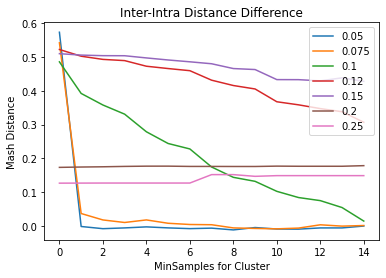

In [23]:
#Now we graph the behaviour of model performance. Here, difference in median intra and inter cluster distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(arange(0,15),AllDiff[0:15],label="0.05")
plot(arange(0,15),AllDiff[15:30],label="0.075")
plot(arange(0,15),AllDiff[30:45],label="0.1")
plot(arange(0,15),AllDiff[45:60],label="0.12")
plot(arange(0,15),AllDiff[60:75],label="0.15")
plot(arange(0,15),AllDiff[75:90],label="0.2")
plot(arange(0,15),AllDiff[90:105],label="0.25")
title("Inter-Intra Distance Difference")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

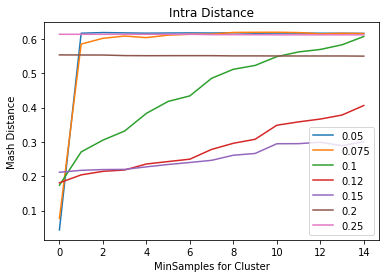

In [26]:
#Next, intra cluster median distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(arange(0,15),AllSameDist[0:15],label="0.05")
plot(arange(0,15),AllSameDist[15:30],label="0.075")
plot(arange(0,15),AllSameDist[30:45],label="0.1")
plot(arange(0,15),AllSameDist[45:60],label="0.12")
plot(arange(0,15),AllSameDist[60:75],label="0.15")
plot(arange(0,15),AllSameDist[75:90],label="0.2")
plot(arange(0,15),AllSameDist[90:105],label="0.25")
title("Intra Distance")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

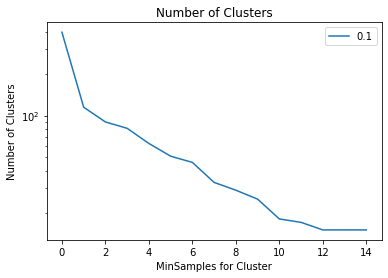

In [32]:
#Finally, the number of clusters.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),NumClusters[0:15],label="0.05")
#plot(arange(0,15),NumClusters[15:30],label="0.075")
plot(arange(0,15),NumClusters[30:45],label="0.1")
#plot(arange(0,15),NumClusters[45:60],label="0.12")
#plot(arange(0,15),NumClusters[60:75],label="0.15")
#plot(arange(0,15),NumClusters[75:90],label="0.2")
#plot(arange(0,15),NumClusters[90:105],label="0.25")
title("Number of Clusters")
xlabel("MinSamples for Cluster")
ylabel("Number of Clusters")
yscale("log")
legend()

#### hdbSCAN

In [43]:
#Now the same thing with HDBSCAN. Comments are the same when the code is the same or equivalent.
import hdbscan

#The parameters tested are the same. 
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
MSamples=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

#We'll save the results of the best output. We'll measure the best one as that which minimizes the distances 
#between members of the same cluster. We don't minimize the median distance between members of the same and 
#different clusters as this might favor a low intercluster distance.

#The parameters to be saved are the intra cluster distance, the number of clusters, and the difference between the 
#inter and intra cluster distances.
HbestEOpt=0
HbestMSamples=0
HleastSame=1000000000
HleastInter=0

#We'll also save the output from every possible combination of parameters.
HAllDiff=[]
HAllSameDist=[]
HNumClusters=[]

#Now we test the parameters. We try every possible combination.
for EO in eOpt:
    for MS in MSamples:
#For each we generate the clusterization using the Mash distance data.
        hdbg=hdbscan.HDBSCAN(eps=EO,metric="precomputed",min_samples=MS)
#We go over the distance matrix and save inter cluster distances in group_distances and intra cluster distances in
#diff_distances.
        cluster_labels = hdbg.fit_predict(distances)
        group_distances=[]
        diff_distances=[]

        for i in range(1,distances.shape[0]):
            for j in range(0,i):
                if cluster_labels[i]==cluster_labels[j]:
                    group_distances.append(distances[i,j])
                else:
                    diff_distances.append(distances[i,j])
#We save the values in the adequate lists.
        HthisDiff=mean(diff_distances)-mean(group_distances)
        HthisDist=mean(group_distances)
        HNumClusters.append((max(cluster_labels)+2))
        HAllDiff.append(HthisDiff)
        HAllSameDist.append(thisDist)

#As a failsafe, we make sure that the median intra group distance is smaller than the median inter group distance.
        if median(diff_distances)<=median(group_distances):
            continue

#If the median intra cluster distance is smaller than the smallest one so far, the parameters for the best 
#clusterization are updated.            
        if HthisDist<HleastSame:
            HbestEOpt=EO
            HbestMSamples=MS
            HleastSame=thisDist
            HleastInter=thisDiff
            

In [ ]:
#We print the parameters of the best models.
print(HbestEOpt)
print(HbestMSamples)
print(HleastSame)
print(HleastInter)

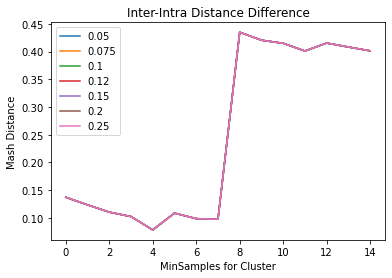

In [44]:
#Now we graph the behaviour of model performance. Here, difference in median intra and inter cluster distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(arange(0,15),HAllDiff[0:15],label="0.05")
plot(arange(0,15),HAllDiff[15:30],label="0.075")
plot(arange(0,15),HAllDiff[30:45],label="0.1")
plot(arange(0,15),HAllDiff[45:60],label="0.12")
plot(arange(0,15),HAllDiff[60:75],label="0.15")
plot(arange(0,15),HAllDiff[75:90],label="0.2")
plot(arange(0,15),HAllDiff[90:105],label="0.25")
title("Inter-Intra Distance Difference")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

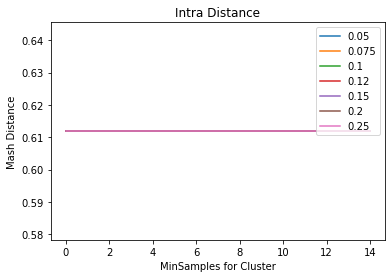

In [45]:
#Next, intra cluster median distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(arange(0,15),HAllSameDist[0:15],label="0.05")
plot(arange(0,15),HAllSameDist[15:30],label="0.075")
plot(arange(0,15),HAllSameDist[30:45],label="0.1")
plot(arange(0,15),HAllSameDist[45:60],label="0.12")
plot(arange(0,15),HAllSameDist[60:75],label="0.15")
plot(arange(0,15),HAllSameDist[75:90],label="0.2")
plot(arange(0,15),HAllSameDist[90:105],label="0.25")
title("Intra Distance")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

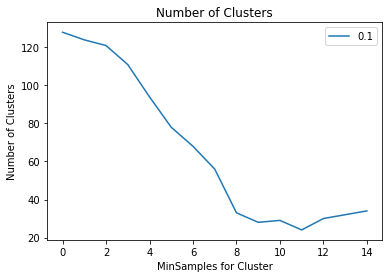

In [46]:
#Finally, the number of clusters.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),NumClusters[0:15],label="0.05")
#plot(arange(0,15),NumClusters[15:30],label="0.075")
plot(arange(0,15),HNumClusters[30:45],label="0.1")
#plot(arange(0,15),NumClusters[45:60],label="0.12")
#plot(arange(0,15),NumClusters[60:75],label="0.15")
#plot(arange(0,15),NumClusters[75:90],label="0.2")
#plot(arange(0,15),NumClusters[90:105],label="0.25")
title("Number of Clusters")
xlabel("MinSamples for Cluster")
ylabel("Number of Clusters")
legend()